# Continuous Cat Weight Measurements in Litter Box

---



---






### Overview:
You are provided with data from two weight bases placed under litter boxes in a pet-owner household with two cats. These bases measure weight and are designed to help monitor the health and habits of the pets. The sensors log data either when there is a weight change of at least 20 grams or every three minutes to provide a baseline health check.

- **Cat A** has a reference weight of 5.5kg.
- **Cat B** has a reference weight of 4.5kg.

### Data Description:
The dataset includes timestamps, weight changes, raw weight values, and device identifiers. Here’s what each column represents:

- tsLogged: Timestamp of the logged data.
- value: The weight measurement (in kg).
- rawValue: The sensor value.
- device_id: Unique identifier for each  base.

Data is given in the **house-hold-measurements-devices.csv**


### Duration:
The data spans from February 1, 2024, to April 18, 2024.


### Objective:
Analyze the data to determine the operation status of the bases, identify and analyze litter box visits, and specifically monitor the weight changes of one of the cats.


## Task 1: Load the data and provide a descriptive analyses

**Objective:**
- Load the provided CSV data into a pandas DataFrame.
- Perform descriptive analysis to summarize the key aspects of the data.
- Create visualizations to aid in understanding the data distribution and identifying any patterns or anomalies.


## Task 1: Determine Base Online/Offline Status

- **Objective:**  Bases are expected to report data every three minutes unless a significant weight change occurs, then it sends updates more often. Analyze the time intervals between consecutive logs to determine when each  Base was online or offline.

- **Expected Output:** A time series visualization showing the periods when each  Base was operational and not operational for over 30 minutes.

## Task 2: Identify Litterbox Visits
- **Objective:** Use weight changes to infer when a litterbox visit occurs. Assume a visit is likely to have occurred when there is a notable weight increase followed by a return to baseline.

- **Expected Output:** A new DataFrame indicating the start and end times of each visit, along with the used device.


## Task 3: Feature Engineering from Visits
- **Objective:** For each identified visit, calculate relevant features such as the duration of the visit, total weight change, and the variability in weight during the visit. Feel free to provide other Features that might be relevant or helpful.

- **Expected Output:** Extend the visits DataFrame to include these new features and provide summary statistics to describe visit patterns.


## Task 4: Analyze Weight Changes for Cat A
- **Objective:** Cat A has a reference weight of approximately 5.5 kg. Filter the visit data to focus on visits likely attributed to Cat A, analyze the weight data, and visualize how this cat’s weight has changed over the monitoring period.

- **Expected Output:** A plot showing the trend of Cat A’s weight changes over time and any notable fluctuations that might indicate health or behavioral issues.


In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from scipy import stats
from copy import deepcopy
import warnings
import time
from google.colab import drive
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the data

In [12]:
data = pd.read_csv('/content/drive/MyDrive/20250116--coding-challenge-data/household-measurements-devices.csv')

In [13]:
data.columns=['ts','value',	'rawValue',	'device_id']
data['ts'] = pd.to_datetime(data['ts'],utc=True)

In [14]:
devices = list(set(data['device_id']))
dining_device = next((device for device in devices if 'dining' in device), None)
office_device = next((device for device in devices if 'office' in device), None)

# Filter DataFrame for dining and office
dining = data.loc[data['device_id'] == dining_device] if dining_device else pd.DataFrame()
office = data.loc[data['device_id'] == office_device] if office_device else pd.DataFrame()

In [15]:
office.head()

,ts,value,rawValue,device_id
53632,2024-02-01 00:00:53+00:00,0.03,615888.25,uuid-device-office-room
53633,2024-02-01 00:03:53+00:00,0.03,615894.75,uuid-device-office-room
53634,2024-02-01 00:06:54+00:00,0.03,615884.50,uuid-device-office-room
53635,2024-02-01 00:09:54+00:00,0.03,615901.25,uuid-device-office-room
53636,2024-02-01 00:12:54+00:00,0.03,615888.75,uuid-device-office-room


### Descriptive Statistics

In [16]:
office.describe()

,value,rawValue
count,60018.000000,60018.000000
mean,1.039538,620117.589019
std,2.481191,62816.980066
min,-10.750000,334010.750000
25%,-0.420000,574407.437500
50%,0.000000,608218.500000
75%,2.480000,652030.500000
max,9.700000,822769.000000


In [17]:
print(f'Total duration of measuring period for office liiter box is : {office.ts.max()-office.ts.min()} starting from {office.ts.min().date()}')
print(f'Total duration of measuring period for dining liiter box is : {dining.ts.max()-dining.ts.min()} starting from {dining.ts.min().date()}')

Total duration of measuring period for office liiter box is : 76 days 23:58:35 starting from 2024-02-01
Total duration of measuring period for dining liiter box is : 76 days 23:59:10 starting from 2024-02-01


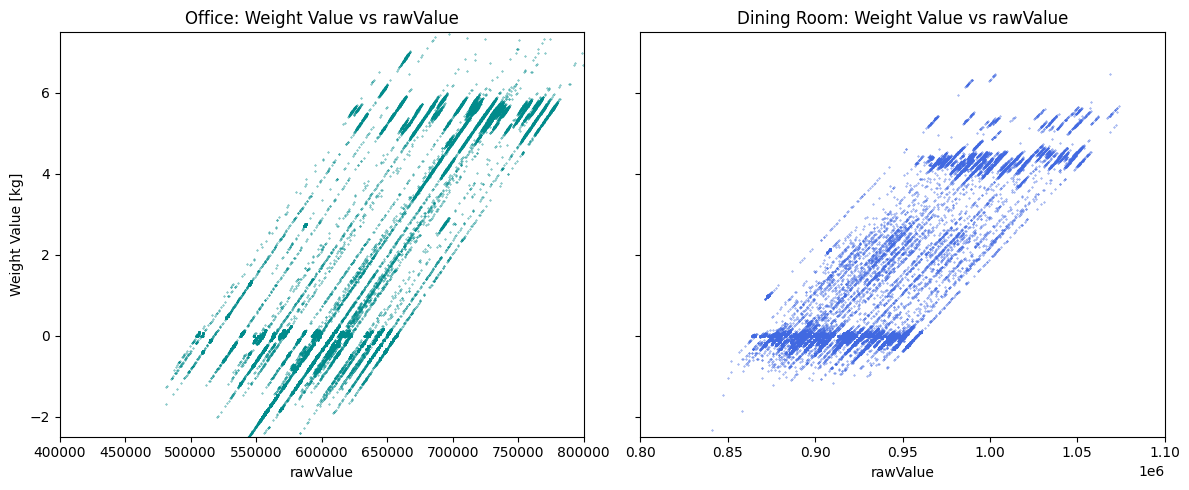

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

# First scatter plot for the "office" data
axes[0].scatter(x=office['rawValue'], y=office['value'], s=0.1,c='darkcyan')
axes[0].set_ylim((-2.5, 7.5))
axes[0].set_xlim((400000, 800000))
axes[0].set_title('Office: Weight Value vs rawValue')
axes[0].set_xlabel('rawValue')
axes[0].set_ylabel('Weight Value [kg]')

# Second scatter plot for the "dining" data
axes[1].scatter(x=dining['rawValue'], y=dining['value'], s=0.1,c='royalblue')
axes[1].set_ylim((-2.5, 7.5))  # Share y-axis with the first plot
axes[1].set_xlim((800000, 1100000))
axes[1].set_title('Dining Room: Weight Value vs rawValue')
axes[1].set_xlabel('rawValue')

plt.tight_layout()
plt.show()


Value vs rawValue shows the linear relationship between the two varaibles. Likely rawValue is a weight metric that periodically gets assign an arbitrary basline. Value is a more baselined weight measurements.

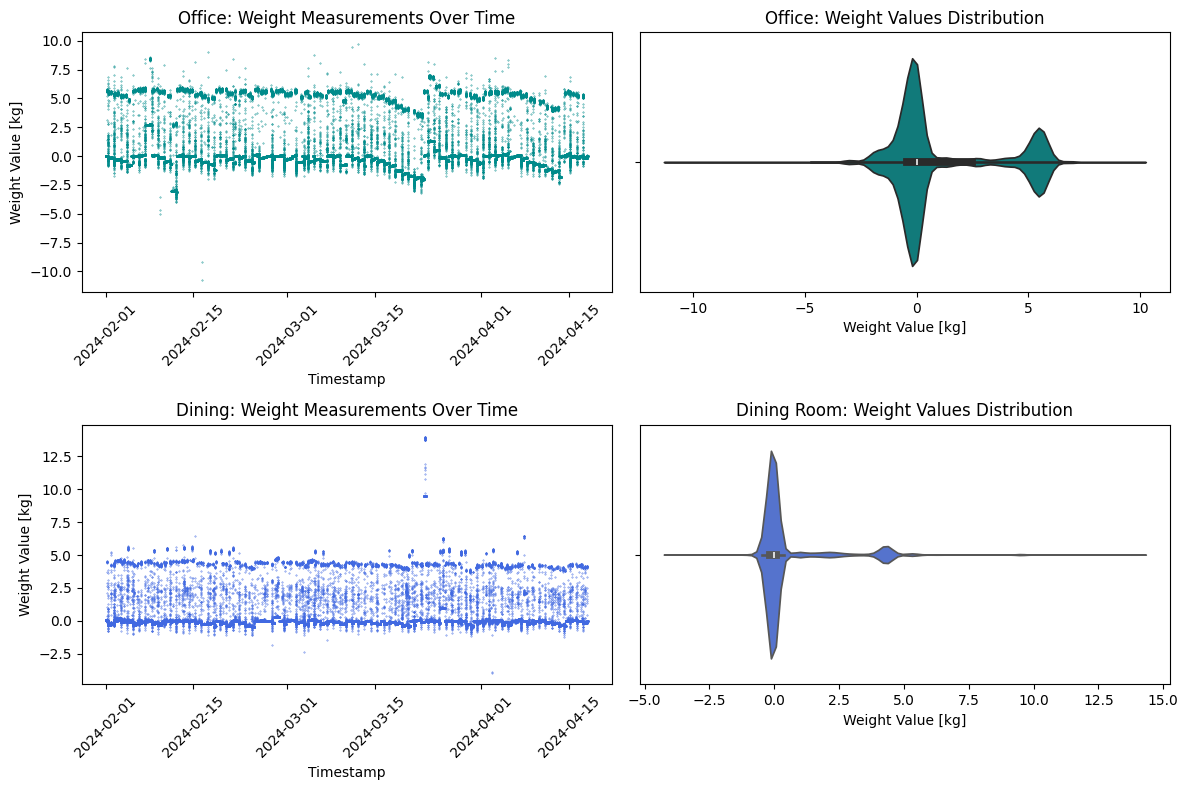

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Scatter plot
axs[0,0].scatter(x=office['ts'], y=office['value'], s=0.1,color='darkcyan')
axs[0,0].set_title('Office: Weight Measurements Over Time')
axs[0,0].set_xlabel('Timestamp')
axs[0,0].set_ylabel('Weight Value [kg]')
axs[0,0].tick_params(axis='x', rotation=45)

# Violin plot
sns.violinplot(x=office['value'], orient='h', ax=axs[0,1],color='darkcyan')
axs[0,1].set_title('Office: Weight Values Distribution')
axs[0,1].set_xlabel('Weight Value [kg]')

# Scatter plot
axs[1,0].scatter(x=dining['ts'], y=dining['value'], s=0.1,color='royalblue')
axs[1,0].set_title('Dining: Weight Measurements Over Time')
axs[1,0].set_xlabel('Timestamp')
axs[1,0].set_ylabel('Weight Value [kg]')
axs[1,0].tick_params(axis='x', rotation=45)

# Violin plot
sns.violinplot(x=dining['value'], orient='h', ax=axs[1,1],color='royalblue')
axs[1,1].set_title('Dining Room: Weight Values Distribution')
axs[1,1].set_xlabel('Weight Value [kg]')

plt.tight_layout()
plt.show()


Value vs Time shows that while Value is more baselined than rawValue its baseline still fluctuates around zero as a result of changes to the litter weight. this could be the result of regular cleaning (scooping) or replacing of the litter.
In addition weight values are either around zero, or ~5kg above the zero, likely the wieght of the cat when it enters the litter box. there are however values between this range. these could be the results of the cat entering/leaving the litter box, or its owners cleaning the litter box. these values will be considered as noise and will be later removed.

### Plotting time differences between measurements as a function of time

In [20]:
office['time_diff'] = office['ts'].diff().dt.total_seconds()
dining['time_diff'] = dining['ts'].diff().dt.total_seconds()

<ipython-input-20-caf20cfeff9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  office['time_diff'] = office['ts'].diff().dt.total_seconds()
<ipython-input-20-caf20cfeff9a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dining['time_diff'] = dining['ts'].diff().dt.total_seconds()


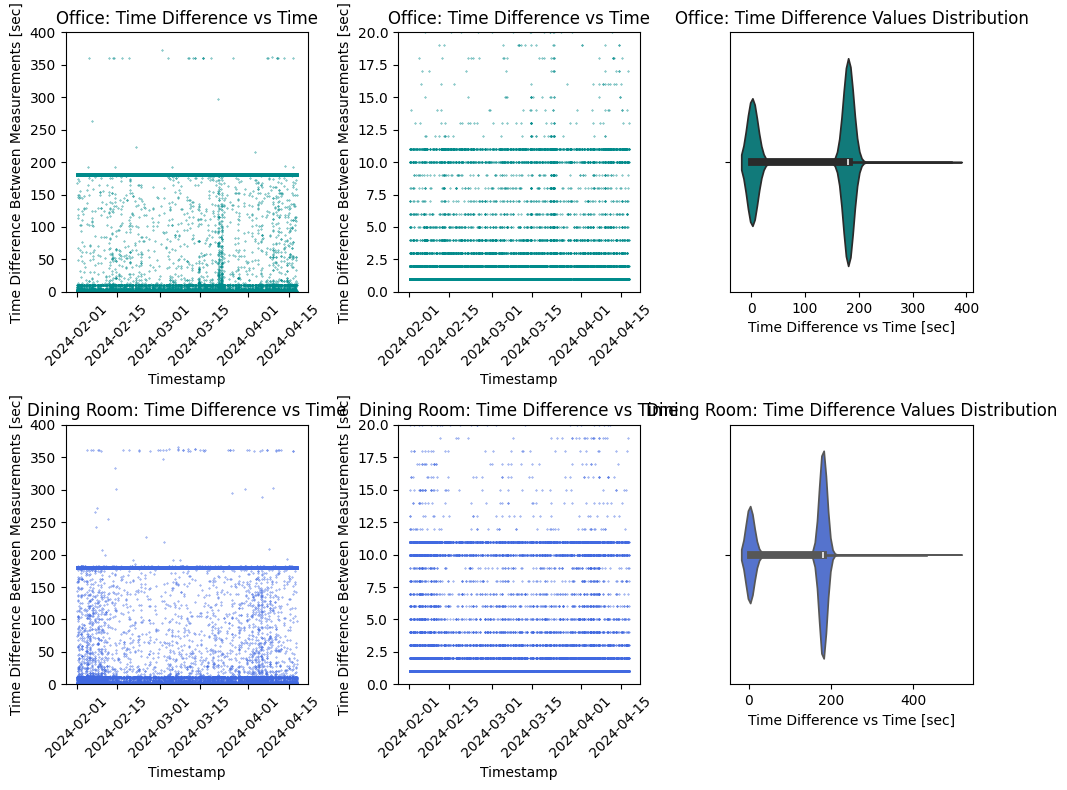

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))


for i,(df,title,clr) in enumerate(zip([office,dining],['Office','Dining Room'],['darkcyan','royalblue'])):

  # Scatter plot
  axs[i,0].scatter(x=df['ts'], y=df['time_diff'], s=0.1,color=clr)
  axs[i,0].set_title(f'{title}: Time Difference vs Time')
  axs[i,0].set_xlabel('Timestamp')
  axs[i,0].set_ylabel('Time Difference Between Measurements [sec]')
  axs[i,0].set_ylim(0,400)
  axs[i,0].tick_params(axis='x', rotation=45)
  # Scatter plot
  axs[i,1].scatter(x=df['ts'], y=df['time_diff'], s=0.1,color=clr)
  axs[i,1].set_title(f'{title}: Time Difference vs Time')
  axs[i,1].set_xlabel('Timestamp')
  axs[i,1].set_ylabel('Time Difference Between Measurements [sec]')
  axs[i,1].set_ylim(0,20)
  axs[i,1].tick_params(axis='x', rotation=45)
  # Violin plot
  sns.violinplot(x=df.loc[df['time_diff']<500,'time_diff'], orient='h', ax=axs[i,2],color=clr)
  axs[i,2].set_title(f'{title}: Time Difference Values Distribution')
  axs[i,2].set_xlabel('Time Difference vs Time [sec]')

plt.tight_layout()
plt.show()


Time Difference Between Weight MeasurementsThe time_diff vs Time shows that there are two major value ranges:

One which is at ~180 seconds, reflecting the times where the device is 'Off' and measured the weight at 3 minute intervals.

Another which is at the range of 1-11 seconds, reflecting times when the device is 'On' and the weight is measured due to frequent changes in weight values. This is due to cat visits, and cleaninig/replacing of the litter.

Values between this ranges are likely due to changing of the device from the 'Off' to the 'On' position. A cat has enter for example, and the time duration between this measurement and the previous one is shorter than 180 seconds.

### Removing noise from measurements
Weight changes that are due to cleaning or replacing of litter will be considered 'noise'


The following calculation will be preformed first on the 'Office' measurements, and later be followed by the "Dining Room" measurement calculations.


In [22]:
def plot_var(df, n_min, n_max, threshold, title):
   """
   Plots weight values and their moving variance, highlighting noise vs signal points.

   Args:
       df: DataFrame with 'ts' (timestamp), 'value' (weight), and 'moving_variance' columns
       n_min: Start index for plotting
       n_max: End index for plotting
       threshold: Variance threshold to classify points as noise/signal
       title: Plot title
   """
   plt.figure(figsize=(12, 4))

   # Select data subset for plotting
   df_subset = df.iloc[n_min:n_max]

   # Plot noise points (variance > threshold)
   mask_noise = df_subset['moving_variance'] > threshold
   plt.scatter(
       x=df_subset.loc[mask_noise]['ts'],
       y=df_subset.loc[mask_noise]['value'],
       s=0.7, label='Noise', alpha=0.7, color='magenta'
   )

   # Plot signal points (variance <= threshold)
   plt.scatter(
       x=df_subset.loc[~mask_noise]['ts'],
       y=df_subset.loc[~mask_noise]['value'],
       s=0.5, label='Signal', alpha=0.5, color='darkcyan'
   )

   # Configure primary axis (weight values)
   plt.xlabel('Date')
   plt.xticks(rotation=45)
   plt.ylabel('Weight Value')
   plt.title(title)

   # Add secondary axis for moving variance
   ax = plt.gca()
   ax2 = ax.twinx()
   ax2.plot(
       df_subset['ts'],
       df_subset['moving_variance'],
       color='darkorange', alpha=0.5, linewidth=0.5, label='Moving Variance'
   )
   ax2.set_ylabel('Weight Variance')

   # Add legends for both axes
   ax.legend(loc='upper left')
   ax2.legend(loc='upper right')

   plt.show()
   return


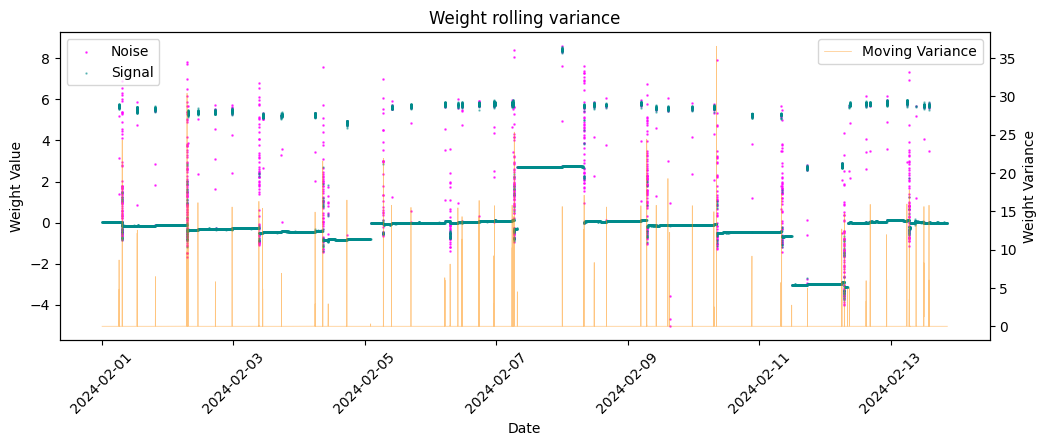

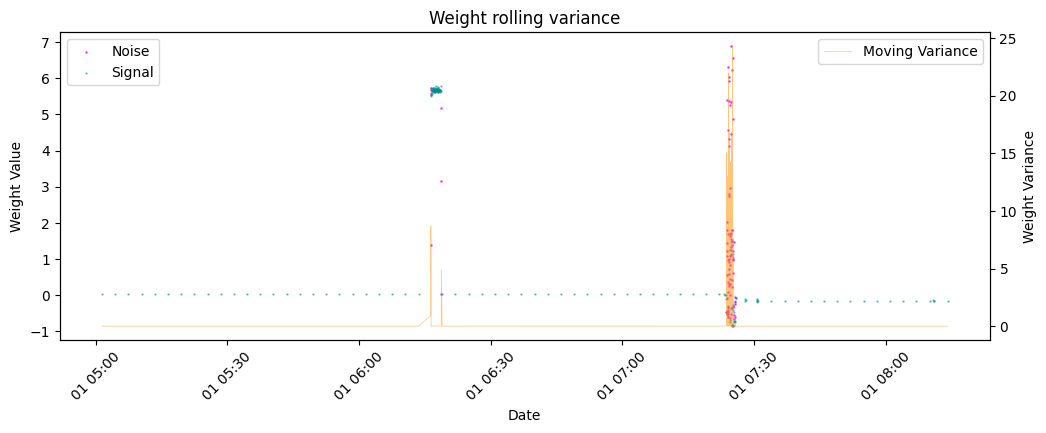

In [23]:
office_copy = office.copy(deep=True)
office_copy['moving_variance'] = office['value'].rolling(window=2).var() # window=2 was selected to provide a sharpest increase and decrease in variance
plot_var(office_copy,0,10000,0.01,'Weight rolling variance')
plot_var(office_copy,100,350,0.01,'Weight rolling variance')



The rolling variance of the weight values is shown in orange. Values that are associated with high variance are colored in magenta, other values are colored in cyan.

The top most plot shows an overview of the weight value rolling variance and its ability to discriminate between true signal (either 'Off' status or 'Litter Box Visit') and noise, i.e. cleaning or replacing the litter.

The bottom plot shows a zoom in into a norrower time range: The variance of the noise is higher than that of actual visits. This is because the change in weight is almost instantaneous when a cat enters or leaves the litter box, in contrast cleaning the litter box causes frequent variations in weight during the cleaning period which cause a more sustained effect on the variance.

This disparity will be used to remove the noise assocaited with cleaning of the litter box.





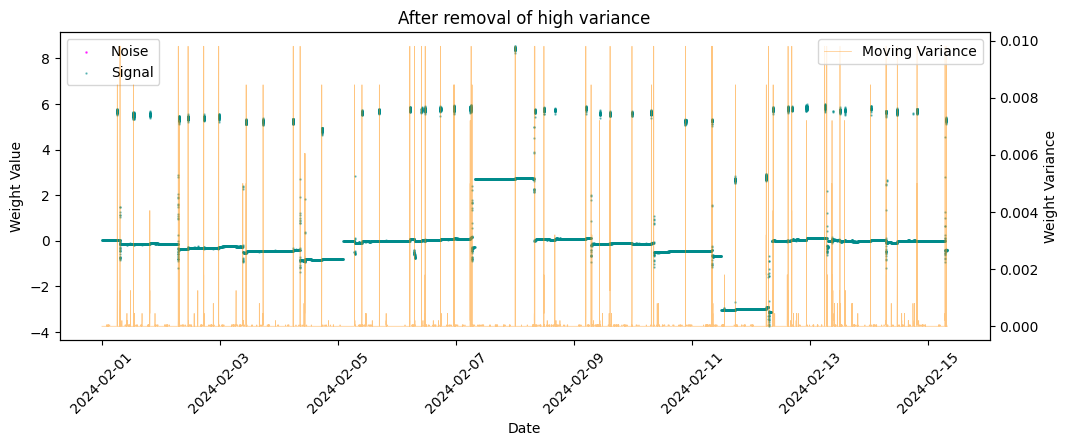

In [24]:
office_copy = office_copy.loc[(office_copy['moving_variance'] < 0.01)]
plot_var(office_copy,0,10000,0.01,'After removal of high variance')



The data is cleaner, but still there are 'noise' signals. I will repeat the process to remove any additional noise measurements.

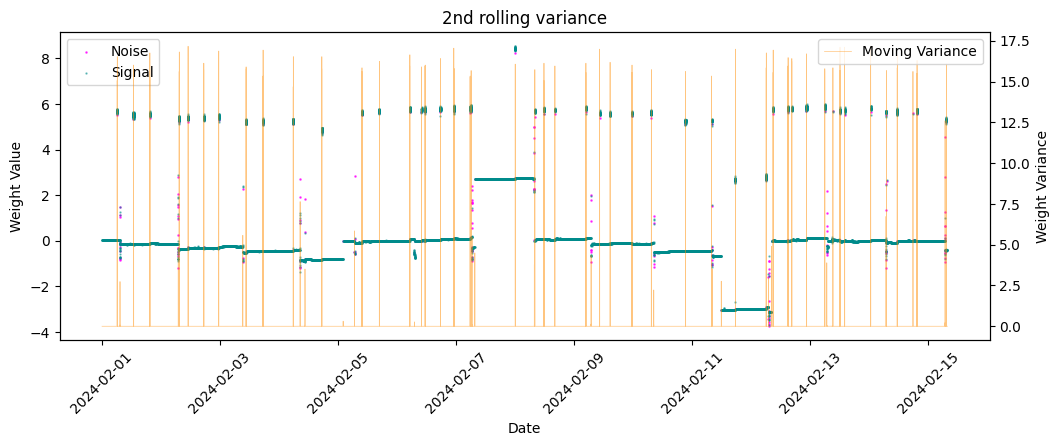

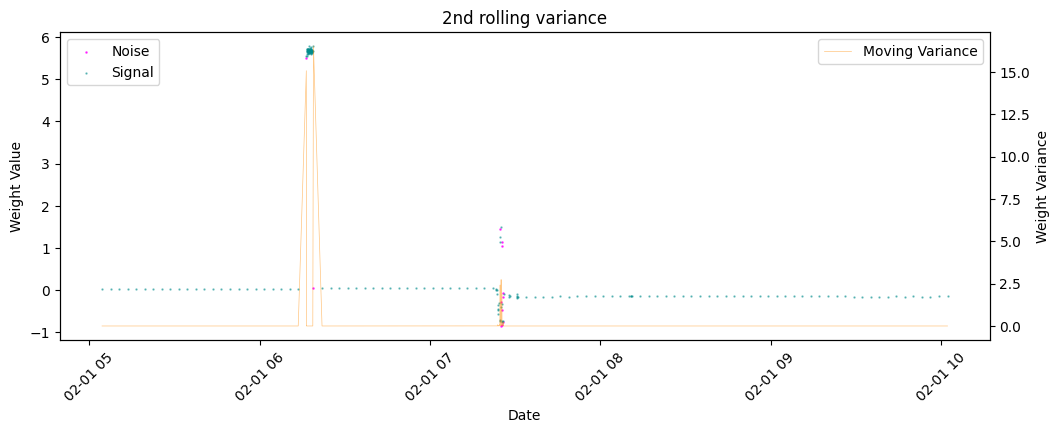

In [25]:
office_copy['moving_variance'] = office_copy['value'].rolling(window=2).var()
plot_var(office_copy,0,10000,0.1,'2nd rolling variance')
plot_var(office_copy,100,300,0.1,'2nd rolling variance')


After the second rolling varaince the varaince associated with the noise signals is lower than that of the actual cat visit. I will remove data that has variance between a lower threshold, associated with 'Off' signal, and high threshold associated with a 'Visit' signal

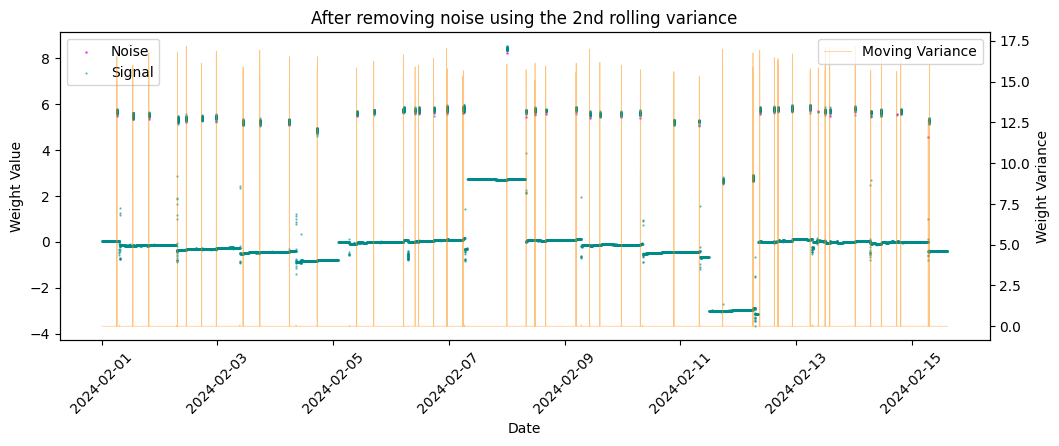

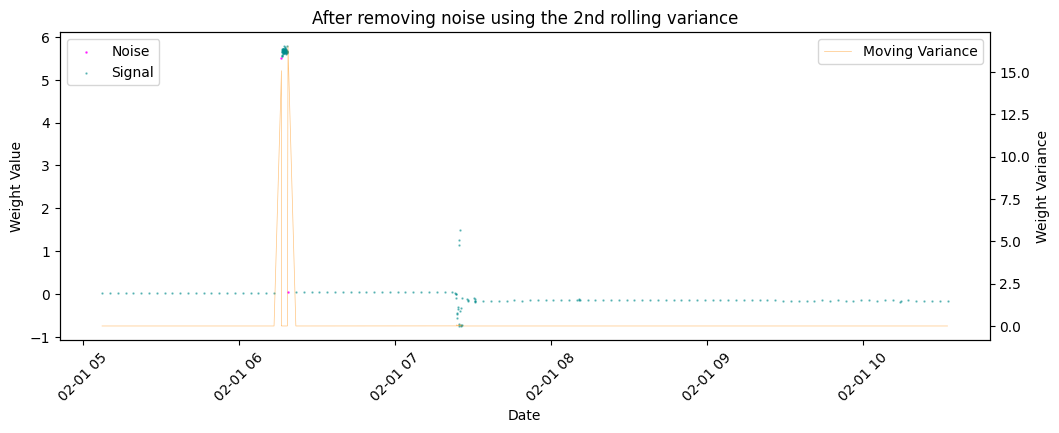

In [26]:
office_copy = office_copy[(office_copy['moving_variance'] < 0.1)|(office_copy['moving_variance'] >10)]
plot_var(office_copy,0,10000,0.1,"After removing noise using the 2nd rolling variance")
plot_var(office_copy,100,300,0.1,"After removing noise using the 2nd rolling variance")


The data is much cleaner now. Theoriticall this process can be repeated an addtional time to remove further noise measurments.

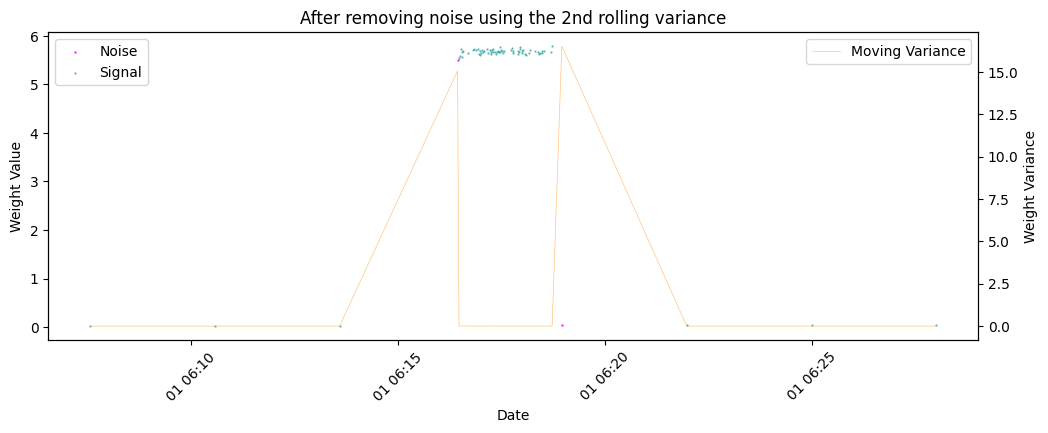

In [27]:
plot_var(office_copy,120,190,0.1,"After removing noise using the 2nd rolling variance")

The plot above shows that when a litter box Visit starts and ends there is a sharp cahnge in weight and associated variance which signals the change from 'off' state to 'on' state and back. I'll make use of this change in variance to calculate various metrics regarding the cat visits to the litter box.

In [28]:
def calc_metrics(df, n_mean, var_lower, var_upper, weight_threshold):
    """
    Calculates weights and durations based on variance thresholds in time series data.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing 'ts' (timestamp), 'value', and 'moving_variance' columns
    n_mean : int
        Number of points to use for mean calculation of baseline "off" status before a visit - to adjust a baseline for each visit. The deafualt value is 10 measurements, corresponding to 30min
    var_lower : float
        Lower threshold for moving variance to identify start of a visit event
    var_upper : float
        Upper threshold for moving variance to identify end of a visit event
    weight_lower : float
        Minimum weight threshold to consider an 'Off' measurement
    n_plot_x : int
        Number of points to plot in visualization

    Returns:
    --------
    pandas.DataFrame
        Results containing litter times, weights, variances, and durations
    """
    # Initialize lists to store various metrics
    litter_durations = []   # Durations of visit event
    interim_durations = []  # Durations between visit events
    weights_baselined = []            # Baseline mean weight of visit event
    litter_time = []        # Timestamps of visit events
    weight_vars = []        # Variances of weights in each visit
    weight_maxs = []        # Maximum weight in each visit
    weight_mins = []        # Minimum weight in each visit

    change = True          # Flag to track state changes between "off" and "visit"
    current_baseline=0
    # Iterate through DataFrame rows
    for idx, row in df.iterrows():
        # Detect start of potential event when variance drops below threshold
        if row['moving_variance'] < var_lower and change:
            start_idx = idx
            change = False

        # Detect change from "off" to "on" or vice versa when variance rises above threshold
        if row['moving_variance'] > var_upper and not change:
            change = True

            # For "off" events, calculate baseline for the next visit and zero out values
            if df.loc[start_idx:idx-1,'value'].mean() < weight_threshold:

                # Calculate baseline using either full period or n_mean points
                # (wanted to avoid a situation where the number of datapoints between consecuitive visits is smaller than the number required for baselining)
                current_baseline = (df.loc[start_idx:idx-1, 'value'].mean()
                                  if idx - start_idx < n_mean
                                  else df.loc[idx-n_mean:idx-1, 'value'].mean())
                df.loc[start_idx:idx,'value'] = 0
                interim_durations.append(df.loc[idx,'ts'] - df.loc[start_idx,'ts'])

            # For "on" visit events, calculate and store metrics
            else:

                weight_baselined = df.loc[start_idx:idx-1,'value'].mean() - current_baseline
                weights_baselined.append(weight_baselined)

                # Calculate variance relative to baseline
                weight_var = (df.loc[start_idx:idx-1,'value'] - current_baseline).var()
                weight_vars.append(weight_var)

                # Store max and min weights of each visit
                weight_max = df.loc[start_idx:idx-1,'value'].max()
                weight_maxs.append(weight_max)
                weight_min = df.loc[start_idx:idx-1,'value'].min()
                weight_mins.append(weight_min)

                # Adjust values by subtracting baseline
                df.loc[start_idx:idx-1,'value'] -= current_baseline

                # Store event timing information
                litter_time.append(df.loc[idx,'ts'])
                litter_durations.append(df.loc[idx,'ts'] - df.loc[start_idx,'ts'])

            # Record duration of event
            df.loc[start_idx:idx-1,'duration'] = df.loc[idx,'ts'] - df.loc[start_idx,'ts']

    # Convert durations from timedelta to minutes
    litter_durations = [t.total_seconds()/60 for t in litter_durations]

    #Calculate wieght range for every visit
    wieght_range = [maxs - mins for maxs, mins in zip(weight_maxs, weight_mins)]
    # Create results DataFrame with all calculated metrics
    results = pd.DataFrame([
        litter_time, weights_baselined, weight_vars, wieght_range,
        litter_durations, interim_durations
    ]).T
    results.columns = [
        'litter_time', 'weight', 'weight_vars', 'weight_range_during_visit',
        'litter_duration', 'interim_durations'
    ]

    return results,df

### Caluclating litter box visits' metrics and ploting the baselined weight variable over time

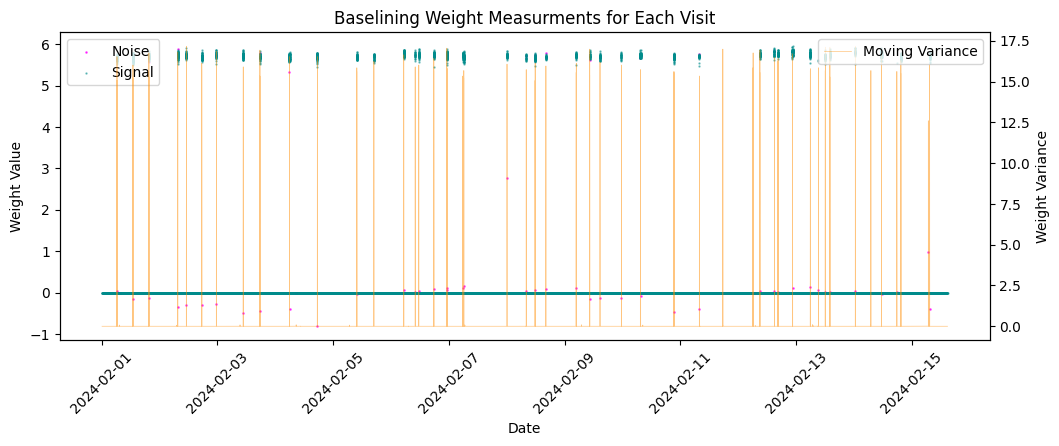

In [29]:
results, office_baselined = calc_metrics(office_copy, n_mean=10, var_lower=0.01, var_upper=10, weight_threshold =4)
plot_var(office_baselined,0,10000,0.01,"Baselining Weight Measurments for Each Visit")

In [30]:
# Remove outliers using IQR method
def remove_outliers(data, column,n_IQR=3):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - n_IQR * IQR
    upper_bound = Q3 + n_IQR * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# violin plots for the specified metrics
def plot_violins(df, metrics, title, figsize=(15, 5)):
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize)
    fig.suptitle(title, fontsize=14, y=1.05)

    cmap = matplotlib.colormaps.get_cmap('magma')
    colors = [cmap(i / (1+len(metrics))) for i in range(len(metrics)+1)]

    for i, metric in enumerate(metrics):
      if metric == 'frequency_per_day':
        unique_days = df[['date', 'frequency_per_day']].drop_duplicates()
        sns.violinplot(y=unique_days[metric], ax=axes[i], color=colors[i+1])
      else:
        sns.violinplot(y=df[metric], ax=axes[i], color=colors[i+1])
      axes[i].set_title(metric)
      axes[i].set_ylabel(metric)

    plt.tight_layout()
    return fig



### Calculating the different metrics' values' distributions

In [31]:
def plot_metric_distributions(df,metrics,n_IQR=3):
  #Removes outliers of the data and plots the distributions

  # Calculate frequency per day
  df['date'] = [d.date() for d in df['litter_time']]
  df['hour_of_day'] = [d.hour for d in df['litter_time']]
  frequency_per_day = df.groupby('date').size().reset_index()
  frequency_per_day.columns = ['date', 'frequency_per_day']
  df = pd.merge(df, frequency_per_day, on='date')

  # Remove outliers from each metric
  results_no_outliers = df.copy()
  for metric in metrics:
    if metric != 'frequency_per_day':
      results_no_outliers = remove_outliers(results_no_outliers, metric,n_IQR)


  # Create violin plots without outliers
  fig = plot_violins(results_no_outliers, metrics, "Distribution of Metrics After Removing Outliers")

  return results_no_outliers

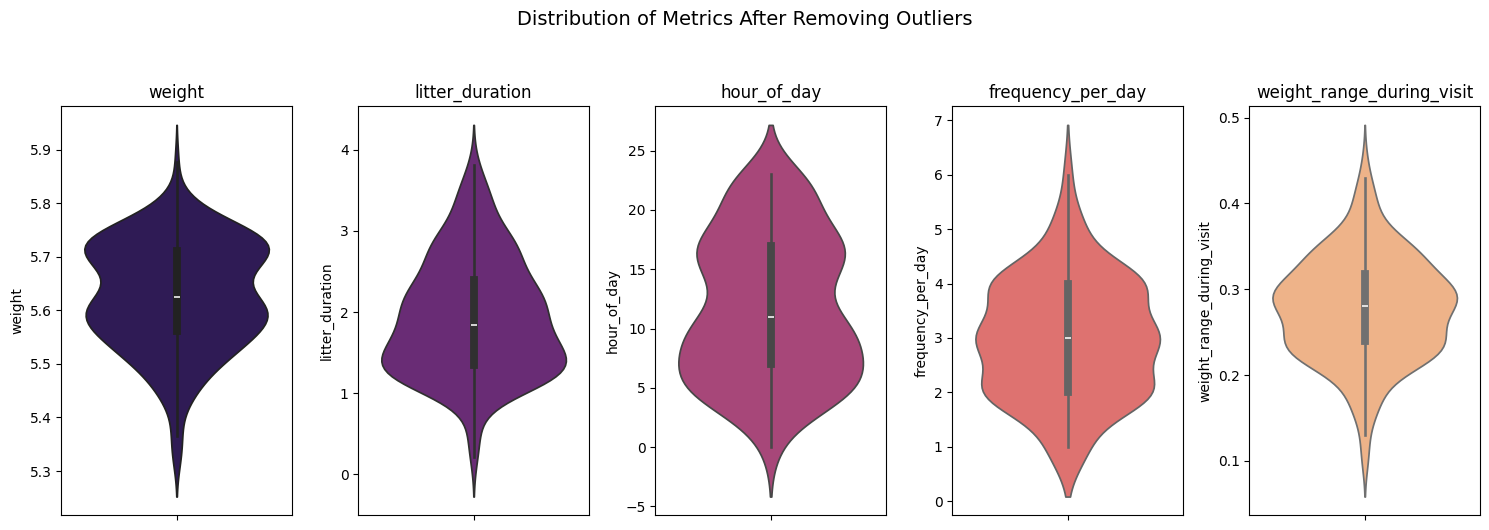

In [32]:
metrics =["weight", "litter_duration", "hour_of_day", "frequency_per_day",'weight_range_during_visit']
results_no_outliers = plot_metric_distributions(results,metrics,n_IQR=1.5)

### Calculating the Office Litter Box's cat weight and its change over the measuring period

In [33]:
def weight_regression(df, plot=True):
    """
    Performs linear regression analysis on weight measurements over time and visualizes results.

    Args:
        df: DataFrame with 'litter_time' (datetime) and 'weight' columns
        plot: Boolean to control plotting

    Returns:
        model: Fitted LinearRegression model
        r_squared: R-squared value of the fit
    """

    # Convert timestamps to days since first measurement
    min_date = df['litter_time'].min()
    df['litter_time'] = df['litter_time'].apply(lambda x: (x - min_date).total_seconds()/(60*60*24))

    # Fit linear regression model
    x = df['litter_time'].values.reshape(-1, 1)
    y = df['weight'].values
    model = LinearRegression()
    model.fit(x, y)

    # Calculate predicted values and R²
    y_pred = model.predict(x)
    r_squared = r2_score(y, y_pred)

    if plot:
        plt.figure(figsize=(10, 4))
        # Plot original data points
        plt.scatter(df['litter_time'], df['weight'], color='darkcyan', label='weight')
        # Plot regression line
        plt.plot(df['litter_time'], y_pred, color='red', label='Regression')

        # Add equation and R² text
        equation = f'y = {model.intercept_:.2f} + {model.coef_[0]:.2e}x'
        r_squared_text = f'R² = {r_squared:.4f}'
        plt.text(df['litter_time'].min(), max(df['weight'])-0.3,
                f'{equation}\n{r_squared_text}', fontsize=12, color='black')

        plt.xlabel('Litter Time [days]')
        plt.ylabel('Weight [kg]')
        plt.title('Weight Regression')
        plt.legend()
        plt.show()

    return model, r_squared

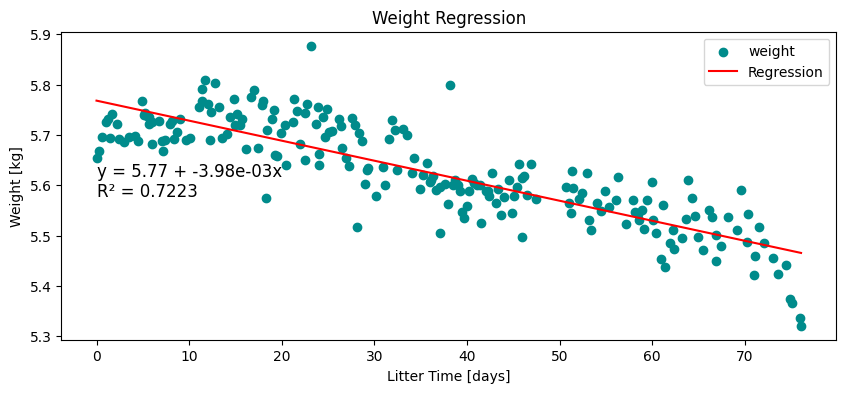

In [34]:
weight_model,weight_r_squared = weight_regression(results_no_outliers)

The cat using the office litter box was ~5.75kg when measurement started. According to the measurements and calcualtions it has dropped 300gr during the measuring period, which are equal to a ~4gr daily average wieght loss.

### Calculating the Office Litter Box's cat frequency of daily visits and its change over the measuring period

In [35]:
def calc_visit_frequency_regression(df):
   """
   Calculates and visualizes linear regression of visit frequency over time.

   Args:
       df: DataFrame with 'date' and 'frequency_per_day' columns

   Returns:
       model: Fitted LinearRegression model
       r_squared: R-squared value of the fit
   """
   # Get unique date-frequency pairs
   unique_summary = df[['date', 'frequency_per_day']].drop_duplicates()

   # Create numerical x-axis for regression (days from start)
   x = np.arange(len(unique_summary['date'])).reshape(-1,1)
   y = unique_summary['frequency_per_day']

   # Fit linear regression model
   model = LinearRegression()
   model.fit(x, y)

   # Calculate predictions and R²
   y_pred = model.predict(x)
   r_squared = r2_score(y, y_pred)

   # Visualization
   plt.scatter(x, y, s=15, color='royalblue')
   plt.plot(x, y_pred, color='firebrick', label='Regression line')

   # Add equation and R² annotation
   equation = f'y = {model.intercept_:.2f} + {model.coef_[0]:.2e}x'
   r_squared_text = f'R² = {r_squared:.4f}'
   plt.text(x.min(), max(y)-0.5,
           f'{equation}\n{r_squared_text}', fontsize=12, color='black')

   plt.title('Frequency of Visits with Regression')
   plt.xlabel('Litter Time [days]')
   plt.ylabel('Frequency of Visits per Day')
   plt.legend()
   plt.tight_layout()
   plt.show()

   return model, r_squared

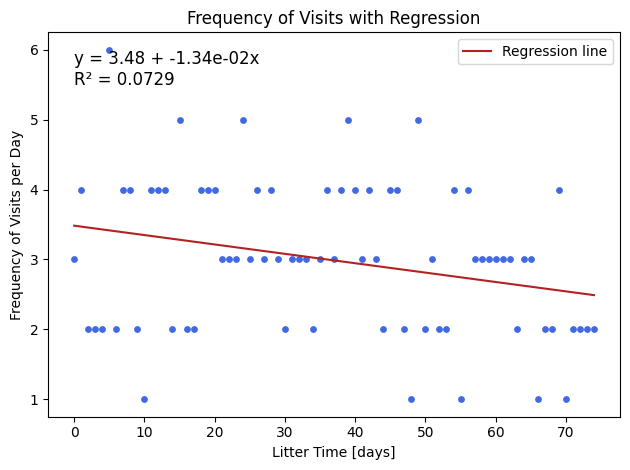

In [36]:
model= calc_visit_frequency_regression(results_no_outliers)

The frequency of visits is ~3 per day. There seems to be a slight decrease in frequency. This could be due to a change in habit, for example using the litter box in the dininig room instead, or some underlying health issue.

## Repeat previous calculations for Dining Room litter box

Since the weight of the cat is lower, the upper variance threshold was adjusted accordingly.

In addition,  since the heavier cat, weighing at ~5.5kg sometime uses this litter box (see four larger-weights visits in the first plots) the definition of outliers was more stringent using 2.5&IQR as threshold, instead of the normal 3*IQR boundaries.

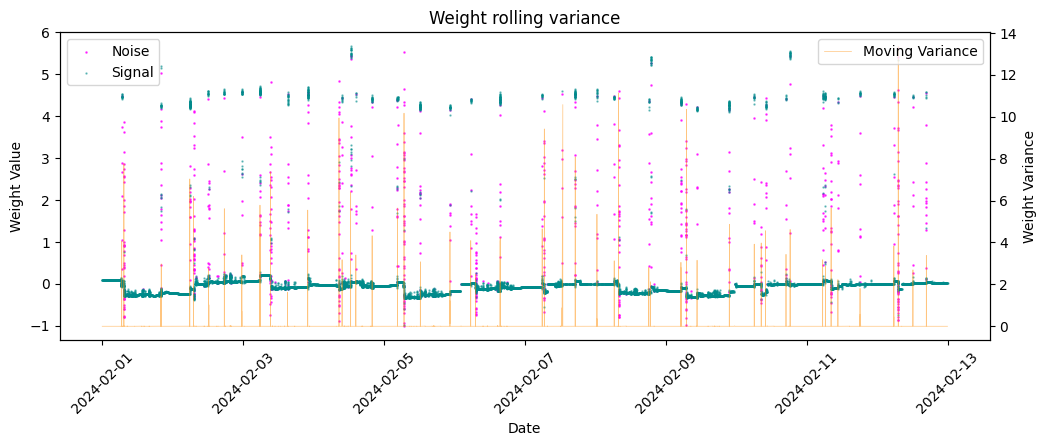

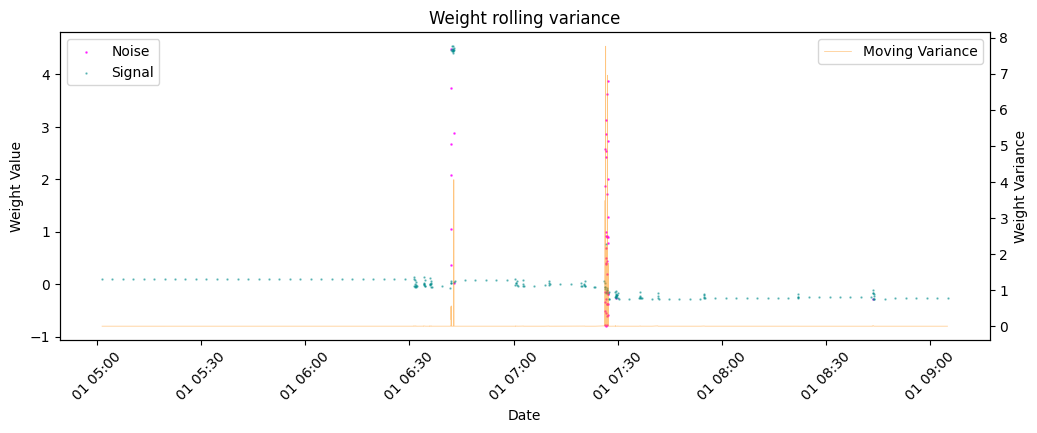

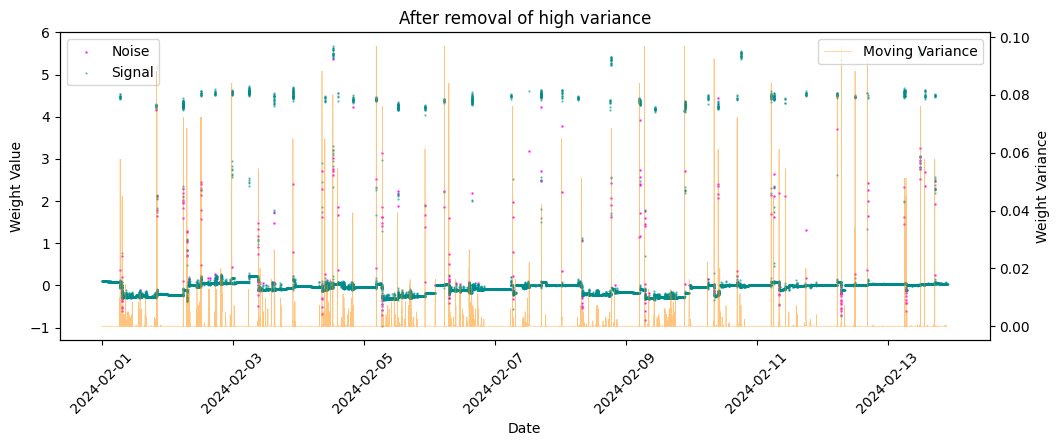

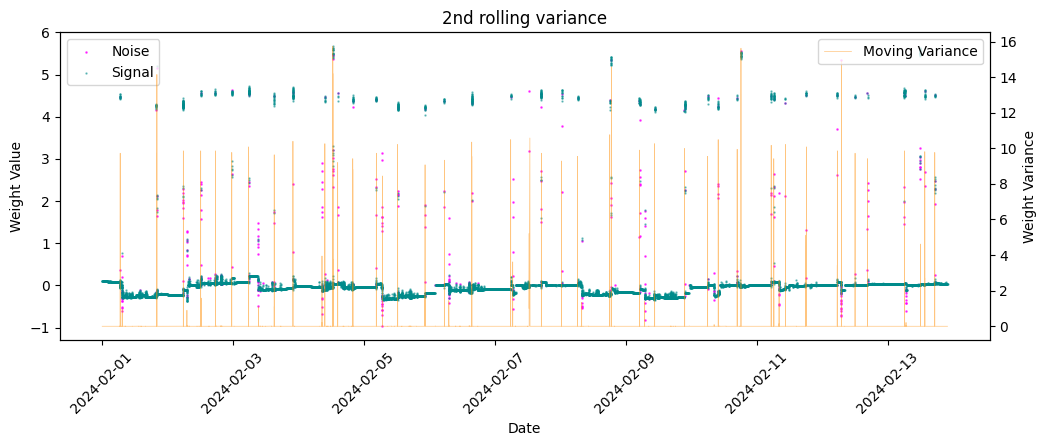

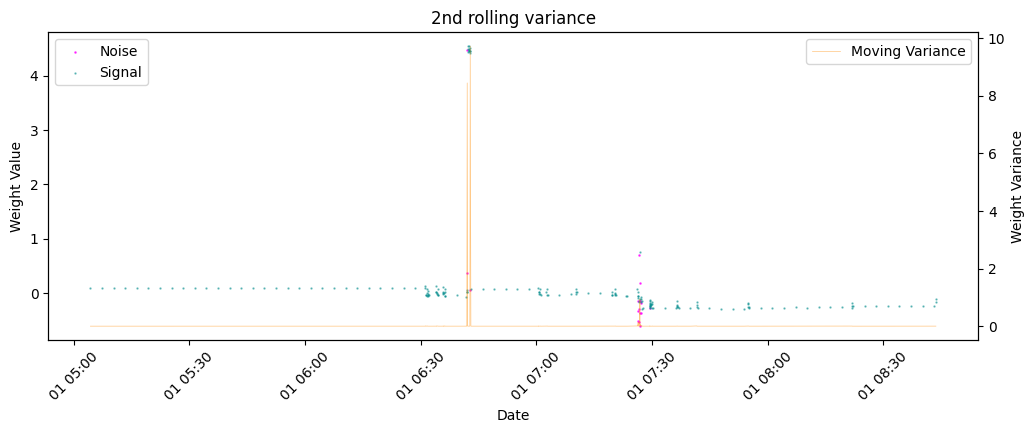

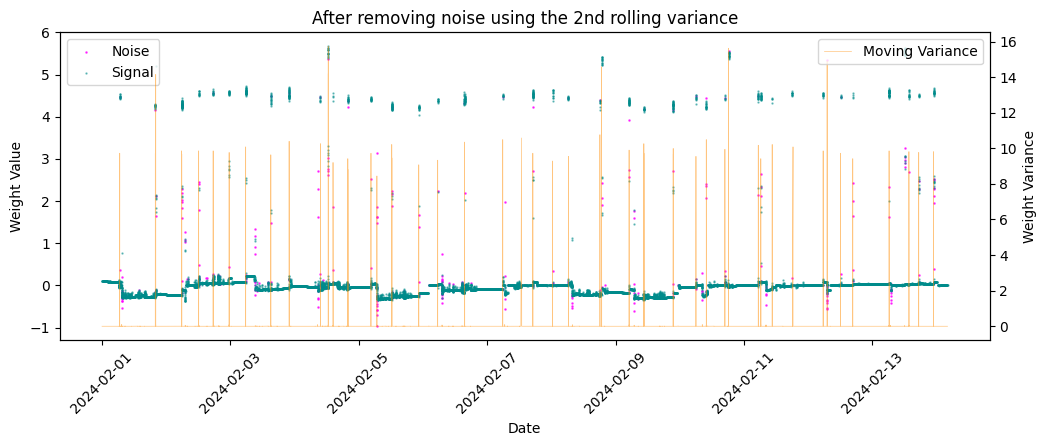

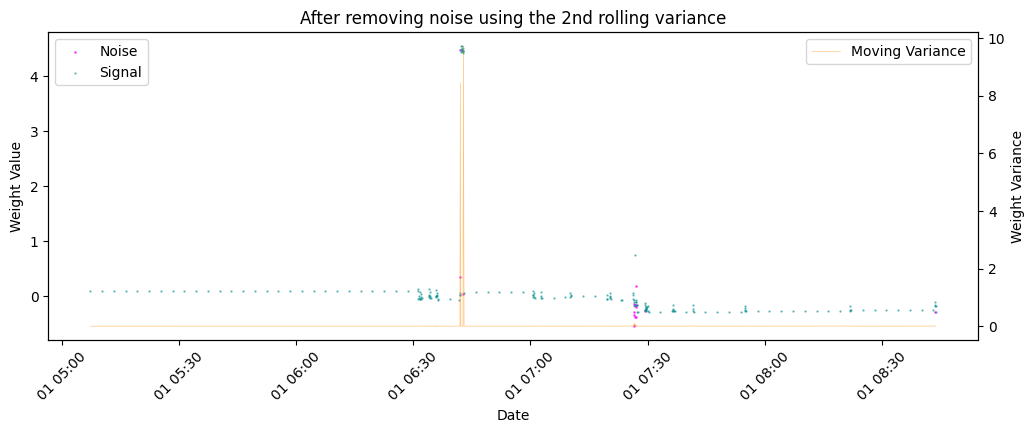

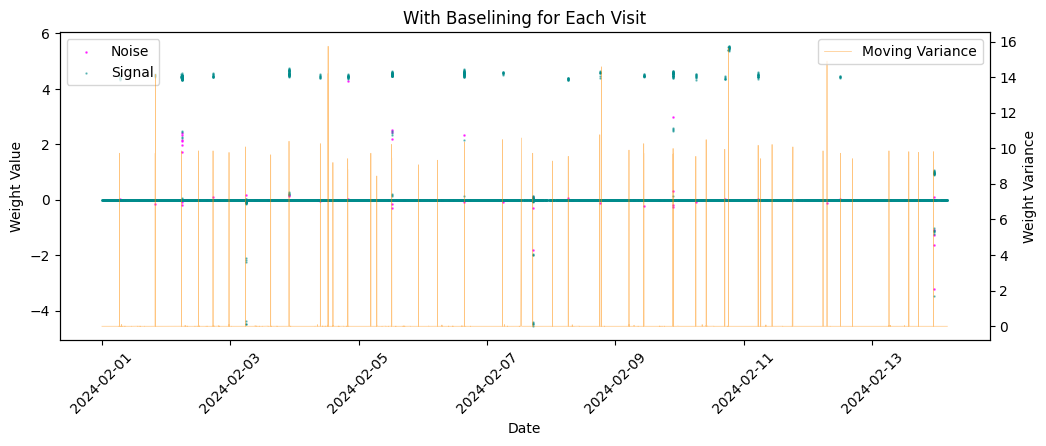

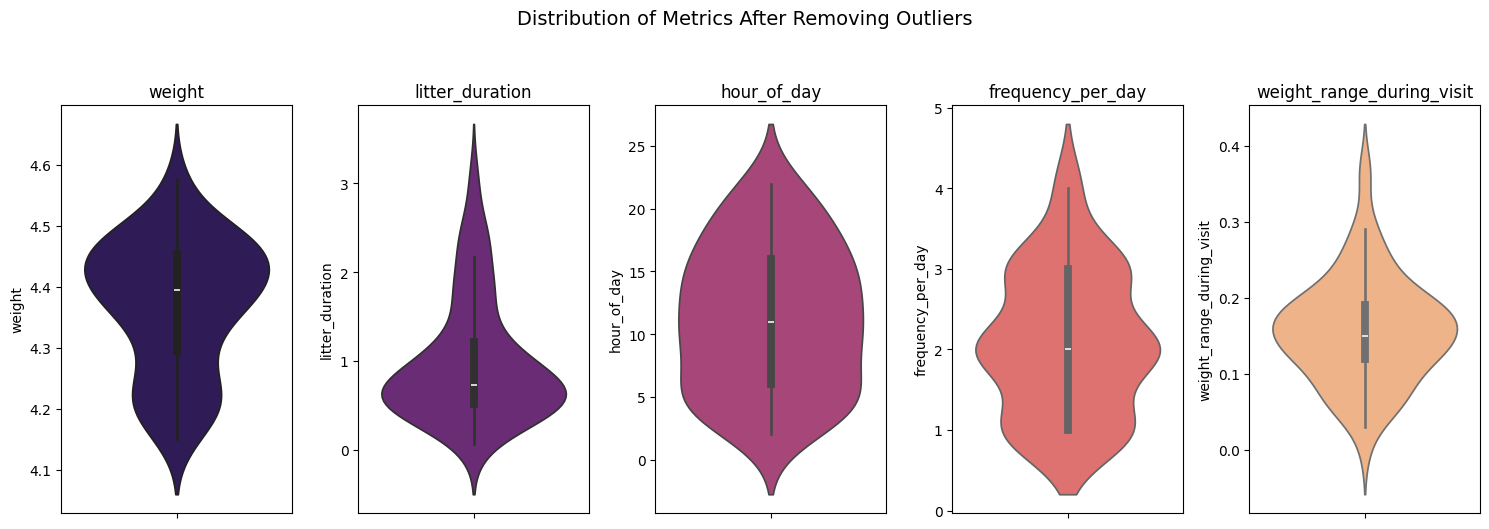

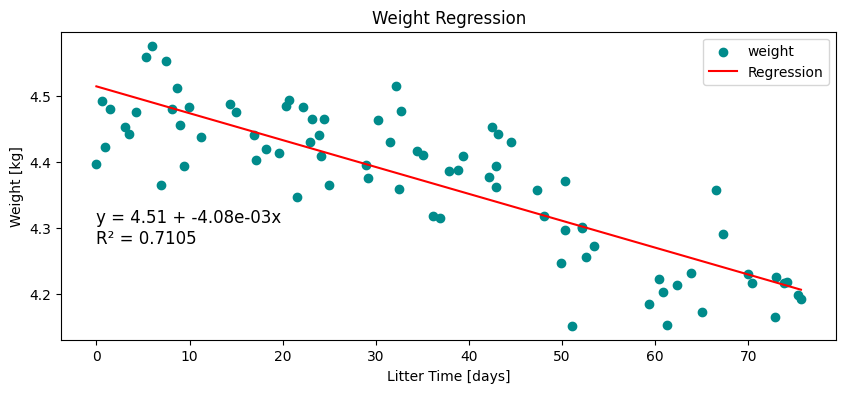

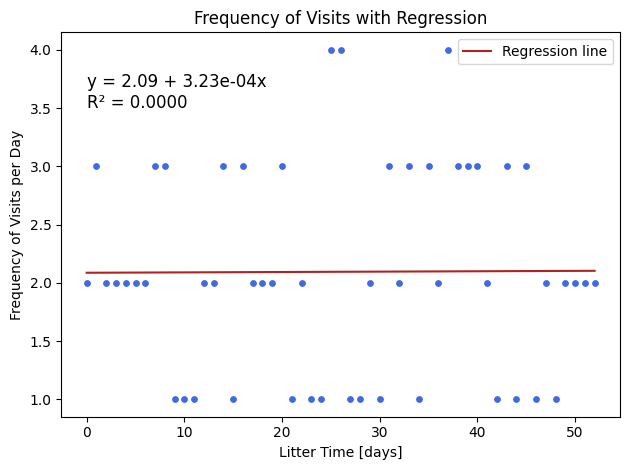

In [37]:
# Create a deep copy to preserve original data
dining_copy = dining.copy(deep=True)

# First pass of variance filtering
dining_copy['moving_variance'] = dining_copy['value'].rolling(window=2).var()  # Calculate rolling variance with window size 2
plot_var(dining_copy, 0, 10000, 0.01, 'Weight rolling variance')  # Plot full range
plot_var(dining_copy, 100, 350, 0.01, 'Weight rolling variance')  # Plot zoomed view

# Remove high variance points (first filter)
dining_copy = dining_copy[(dining_copy['moving_variance'] < 0.1)]
plot_var(dining_copy, 0, 10000, 0.01, 'After removal of high variance')

# Second pass of variance filtering
dining_copy['moving_variance'] = dining_copy['value'].rolling(window=2).var()
plot_var(dining_copy, 0, 10000, 0.01, '2nd rolling variance')  # Plot full range
plot_var(dining_copy, 100, 300, 0.01, '2nd rolling variance')  # Plot zoomed view

# Remove noise using both lower and upper variance thresholds
dining_copy = dining_copy[(dining_copy['moving_variance'] < 0.1) | (dining_copy['moving_variance'] > 7)]
plot_var(dining_copy, 0, 10000, 0.01, "After removing noise using the 2nd rolling variance")  # Plot full range
plot_var(dining_copy, 100, 300, 0.01, "After removing noise using the 2nd rolling variance")  # Plot zoomed view

# Calculate metrics and baseline the data
dining_results, dining_baselined = calc_metrics(dining_copy,
                                              n_mean=10,         # Number of points for moving mean
                                              var_lower=0.1,     # Lower variance threshold
                                              var_upper=7,       # Upper variance threshold
                                              weight_threshold=3)

# Plot baselined results
plot_var(dining_baselined, 0, 10000, 0.01, "With Baselining for Each Visit")

# Define metrics for distribution analysis
metrics = ["weight", "litter_duration", "hour_of_day",
          "frequency_per_day", 'weight_range_during_visit']

# Remove outliers and perform regression analysis
dining_results_no_outliers = plot_metric_distributions(dining_results, metrics, n_IQR=1.5)  # Remove outliers using IQR method
weight_model, weight_r_squared = weight_regression(dining_results_no_outliers)              # Analyze weight trends
model = calc_visit_frequency_regression(dining_results_no_outliers)                         # Analyze visit frequency trends

The cat that uses uses the litter box in the dining room (usually) weighted ~4.5kg when the measuremnet started. It looks like it also dropped 300gr during this period, which correspond to ~4gr daily.

The Cat;s frequency of litter box visits hasn't changed during this period.